In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
import plotly
import sklearn

print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)
print("plotly:     ", plotly.__version__)

package版本信息：
numpy:       1.21.2
pandas:      1.3.3
matplotlib:  3.4.3
sklearn:     0.24.2
seaborn:     0.11.2
plotly:      5.3.1


In [45]:
# 设置显示所有的列
pd.options.display.max_columns = None
# 设置显示所有的行
pd.options.display.max_rows = None

# 阻止waring显示
import warnings
warnings.filterwarnings('ignore')

# jupyter notebook设置同一个cell打印多个结果
from IPython.display import display
# 然后使用
# display("a")
# display("b")

In [46]:
%cd ..

D:\Project-Workspace\Python-Projects


In [49]:
%pwd

'D:\\Project-Workspace\\Python-Projects\\DataAnalysis'

# 数据预处理

+ 数据预处理是从数据中检测，纠正或删除损坏，不准确或不适用于模型的记录的过程。
+ 可能面对的问题有：数据类型不同，比如有的是文字，有的是数字，有的含时间序列，有的连续，有的间断。  
也可能数据的质量不行，有噪声，有异常，有缺失，数据出错，量纲不一，有重复，数据是偏态，数据量太
大或太小
+ 数据预处理的目的：让数据适应模型，匹配模型的需求

## 特征类型

特征（属性）的不同类型，通常用该属性支持的数学操作来定义，常用的数学操作有：
  1. 相异性：$=$ 和 $\not=$
  2. 顺序比较：$\le$ 和 $\ge$
  3. 加减法：$+$ 和 $-$
  4. 乘除法：$\times$ 和 $/$

利用上述的性质，可以定义如下四种类型的特征（属性）

+ 类别属性（定性）
  + 标称属性，只支持 $=$ 和 $\not=$ 的操作（也就是离散属性）——**这类属性需要进行one-hot编码**  
    例子：性别
  + 序数属性，进一步支持 $\le$ 和 $\ge$ 操作——这类属性**不能使用one-hot编码，应当编码为整数序号**  
    例子：等级
+ 数值属性（定量）
  + 区间属性，进一步支持 $+$ 和 $-$ 操作，属性值之间的和与差是有意义的  
    例子：**日期**
  + 比率属性，支持 $\times$ 和 $/$ 操作，属性值之间的差、积、商都是有意义的  
    比率属性的**取值通常是无数个**，并且可以进一步细分为：
    + **实数**型，这类特征就是通常意义上的连续属性
    + **正整数**，这类特征通常是**计数属性**，并且需要做处理，不能直接当连续型来使用

> 实际操作中，对于比率属性，特别要注意的是**检查取值范围和分布**，如果横跨多个数量级，一般情况下需要进行**分箱操作**。
>
> 特别是计数属性，通常**计数属性的分布很不均匀**，横跨的数量级也很大，通常采用二值化或者分箱操作。



## 缺失值处理

有两个处理框架：

+ `sklearn.impute`中提供了进行缺失值填充的类，主要有：
  1. `SimpleImputer()`，提供了如下填充策略 (`strategy=`)：
    + `mean`，均值填充，仅适用于数值型
    + `median`，中位数填充，仅适用于数值型
    + `most_frequent`，众数填充，对数值型和**字符型**特征都可用
    + `constant`，常数填充，配合`fill_value`参数使用，对数值型和**字符型**特征都可用
  2. `KNNImputer()`


+ pandas提供的`DataFrame.fillna()` ：
提供了向前填充，向后填充，常数填充这几种填充策略。

一般来说，使用pandas进行填充比较方便，不过如果要使用均值等统计量来填充，使用sklearn更为方便。
特别要注意的是，**sklearn中的策略是对所有特征一起使用的，如果传入的数据里字符型和数值型特征混用，会报错**。

所以，**推荐使用pandas进行缺失值处理**。

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
# df1 中含有非数值的列
df1 = pd.DataFrame({'a':[1,2,2,np.nan], 'b':['A','A',None, 'B']})

# df2中全是数值
df2 = pd.DataFrame({'a':[1,2,2,np.nan], 'b':[10,None,15,20]})

+ 可以看出，pandas中的`fillna()`可以处理**非数值列**，而sklearn不行

In [5]:
df1.fillna(0)

,a,b
0,1.0,A
1,2.0,A
2,2.0,0
3,0.0,B


In [7]:
df1.fillna(method='ffill')

,a,b
0,1.0,A
1,2.0,A
2,2.0,A
3,2.0,B


In [9]:
df1.fillna(method='backfill')

,a,b
0,1.0,A
1,2.0,A
2,2.0,B
3,NaN,B


In [12]:
# imp = SimpleImputer(strategy='mean')
# imp = SimpleImputer(strategy='most_frequent')
imp = SimpleImputer(strategy='constant', fill_value='FILL')
imp.fit(df1)

SimpleImputer(add_indicator=False, copy=True, fill_value='FILL',
              missing_values=nan, strategy='constant', verbose=0)

In [13]:
imp.transform(df1)

array([[1.0, 'A'],
       [2.0, 'A'],
       [2.0, None],
       ['FILL', 'B']], dtype=object)

+ 统计各列缺失值信息的函数

In [22]:
def miss_stat(df):
    """
    用于统计DF中各列的缺失值信息和占比
    """
    miss_num = df.isnull().sum()
    # 只展示有缺失值的特征
    miss_num = miss_num[miss_num > 0]
    total = df.shape[0]
    miss_percent = miss_num/total*100
    miss_info = pd.concat([miss_num, miss_percent, df.dtypes], axis = 1, keys=['miss_num', 'miss_percent','dtype'])
    miss_info['total'] = total
    miss_info = miss_info[['miss_num','total','miss_percent','dtype']]
    miss_info.dropna(inplace=True)
#     降序排列，同时设置小数点的位数
    miss_info = miss_info.sort_values(by=['miss_num'],ascending=False).round(decimals=3)
#     打印
#     from IPython.display import display
    print("miss_stat.shape: ", miss_info.shape)
    print("miss_stat:")
    display(miss_info)
#     print(miss_info)
    return miss_info

+ 对缺失值进行填充的函数

In [199]:
# 缺失值填充函数
def Fill_na(df, numerical_cols=None, discrete_cols=None):
    """
    对数值特征使用均值填充，对离散特征使用众数填充
    """
    df = df.copy()
    if numerical_cols is not None:
        # df.mean()返回的是一个series，可以直接用.to_dict()
        num_mean_dict = df[numerical_cols].mean(axis=0).to_dict()
        # 不知道为什么，下面这一句，是对 copy 进行的操作，而不是对 view 进行的操作
        # df[numerical_cols].fillna(value=num_mean_dict, inplace=True)
        df[numerical_cols] = df[numerical_cols].fillna(value=num_mean_dict)

    if discrete_cols is not None:
        # df.mode() 返回的是一个DataFrame，调用to_dict()后还需要进一步处理
        mode_dict = df[discrete_cols].mode(axis=0).to_dict()
        discrete_mode_dict = {}
        for key in mode_dict.keys():
            discrete_mode_dict[key] = mode_dict[key][0]
        # df[discrete_cols].fillna(value=discrete_mode_dict, inplace=True)
        df[discrete_cols] = df[discrete_cols].fillna(value=discrete_mode_dict)
    return df

## 数值特征检查

一般对于数值型特征，需要考虑做如下的检查：

1. 数量级  
   比如特征是否均为正值，一般的数量级是多少
   
2. 尺度  
   比如特征的**取值范围**，是否横跨多个数量级，这个很重要——**如果模型是输入特征的平滑函数，那么该模型对于特征的尺度是非常敏感的**：
   + 所有使用欧式距离的模型，比如$y=3\times x+1$，k-均值聚类等，输入特征的尺度变化会直接影响模型输出。  
     对于这类模型，通常需要将特征进行**标准化**，以便将输出控制在期望的范围之内。
   + 逻辑回归对于输入特征的尺度并不敏感
   + 一般来说，树模型对于输入特征的尺度也不敏感
   
3. 分布  
   通常会要求输入特征服从高斯分布，可以考虑使用**对数变换**实现。  
   此外，更加常见的情况是，预测目标也需要做这样的对数变换！！！

## 特征缩放

定义：`将不同规格的数据转换到同一规格，或不同分布的数据转换到某个特定分布`。  

作用：
+ 在**以梯度和矩阵为核心**的算法中，譬如逻辑回归，支持向量机，神经网络，特征缩放可以加快求解速度
+ 涉及到**距离计算**的模型，譬如K近邻，K-Means聚类中，特征缩放可以帮我们**提升模型精度，避免某一个取值范围特别大的特征对距离计算造成影响**

注意：
> + 对于树模型，一般不需要做特征缩放处理，因为它们对于特征尺度并不敏感。  
> + 对于大部分为0的稀疏数据，不要使用上述的缩放，特别是min-max和标准化，因为这两种变换都会将原始值平移一段距离，因此**会将稀疏特征向量变成密集特征向量**！！！


常见的特征缩放有如下方式：

### 归一化  

使用最大值和最小值来进行归一化，将数据缩放到 $[0, 1]$ 之间.

sklearn中提供了如下的类实现该操作，并且在标准的基础上增加了缩放到指定区间（feature_range参数）的操作，原理如下.  
设 feature_range= $[min, max]$，给定数据X，最大值和最小值分别为 $[X_{min}, X_{max}]$，那么归一化公式为：  

$\tilde{x} = \frac{x - X_{min}}{X_{max} -- X_{min}} (max - min) + min = x  \frac{max - min}{X_{max} -- X_{min}} + min - X_{min} \frac{max-min}{X_{max} -- X_{min}}$,  

其中的 $\frac{max - min}{X_{max} -- X_{min}}$ 被称为 scale，$min - X_{min} \frac{max-min}{X_{max} -- X_{min}}$ 被称为 min。

+ `preprocessing.MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)`  
  对象属性：
  + min_: shape=(n_features, )
  + scale_: shape=(n_features, )
  + data_min_, data_max_: shape=(n_features, )，每个特征实际的最大、最小值
  + data_range_: shape=(n_features, )，每个特征的数据范围，注意，它是最大值-最小值
  + n_features_in_: 特征数量
  + n_samples_seen_: 样本数量
  + features_names_in_: shape=(n_features, )


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = np.array([[1, 2], [3, 4], [5, 6]])
print(X)
scaler.fit(X)

[[1 2]
 [3 4]
 [5 6]]


MinMaxScaler()

In [17]:
print('scaler.min_: ', scaler.min_)
print('scaler.scale_: ', scaler.scale_)
print('scaler.data_min_: ', scaler.data_min_)
print('scaler.data_max_: ', scaler.data_max_)
print('scaler.data_range_: ', scaler.data_range_)
print('scaler.n_features_in_: ', scaler.n_features_in_)
print('scaler.n_samples_seen_: ', scaler.n_samples_seen_)

scaler.min_:  [-0.25 -0.5 ]
scaler.scale_:  [0.25 0.25]
scaler.data_min_:  [1. 2.]
scaler.data_max_:  [5. 6.]
scaler.data_range_:  [4. 4.]
scaler.n_features_in_:  2
scaler.n_samples_seen_:  3


In [18]:
scaler.transform(X)

array([[0. , 0. ],
       [0.5, 0.5],
       [1. , 1. ]])

根据上面的公式，归一化的结果也可用下面的方式得到：

In [19]:
X * scaler.scale_ + scaler.min_

array([[0. , 0. ],
       [0.5, 0.5],
       [1. , 1. ]])

### 标准化  

减去均值，然后除以标准差，实现均值=0，方差=1的标准化.  

+ `preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)`   
  参数
  + with_mean: 是否减去均值，默认为True
  + with_std: 是否除以方差，默认为True
  
  属性
  + scale_: 每个特征的系数
  + mean_: 每个特征的均值
  + var_: 每个特征的方差
  + n_features_in_: 特征数量
  + n_samples_seen_: 样本数量
  + features_names_in_: shape=(n_features, )

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = np.array([[1, 2], [3, 4], [5, 6]])
print(X)
scaler.fit(X)

[[1 2]
 [3 4]
 [5 6]]


StandardScaler()

In [31]:
print('scaler.mean_: ', scaler.mean_)
print('scaler.scale_: ', scaler.scale_)
print('scaler.var_: ', scaler.var_)
# 实际上 scale_ 就是 var_ 开方得到
print('np.sqrt(scaler.var_): ', np.sqrt(scaler.var_))
print('scaler.n_features_in_: ', scaler.n_features_in_)
print('scaler.n_samples_seen_: ', scaler.n_samples_seen_)

scaler.mean_:  [3. 4.]
scaler.scale_:  [1.63299316 1.63299316]
scaler.var_:  [2.66666667 2.66666667]
np.sqrt(scaler.var_):  [1.63299316 1.63299316]
scaler.n_features_in_:  2
scaler.n_samples_seen_:  3


In [26]:
scaler.transform(X)

array([[-1.22474487, -1.22474487],
       [ 0.        ,  0.        ],
       [ 1.22474487,  1.22474487]])

也可以通过下述方式得到同样的结果：

In [28]:
(X - scaler.mean_)/scaler.scale_

array([[-1.22474487, -1.22474487],
       [ 0.        ,  0.        ],
       [ 1.22474487,  1.22474487]])

### 中心化  
中心化直接通过pandas实现就好了，不需要sklearn

### 范数归一化  
`preprocessing.Normalizer()`

### 分位数标准化  
`preprocessing.RobustScaler()`

# 特征编码

## One-Hot编码、Dummy编码和Effective编码

+ One-Hot编码：将有$k$类别的分类变量编码成一个长度为$k$的 0-1 向量，不过这种方式使用的比特位要多一位，它有$k$个自由度。
+ Dummy编码(dummy coding)：只使用长度为$k-1$的 0-1 向量，也因此只有$k-1$个自由度。
+ Effective编码(effective coding)：和虚拟编码类似，但是它的参照类取值是-1，而不是0，相比较于虚拟编码，它的区别在于使线性模型更加容易解释。

pandas中提供了用于实现前两种编码的方法：  
+ `pandas.get_dummies(data, columns=None, drop_first=False, dtype=np.unit8, prefix=None, prefix_sep='_', sparse=False)`
  + data：数据
  + columns: list，指定需要编码的列名
  + drop_first: 是否保留第一个level的编码，也就是在one-hot和dummy中选择，默认为False，也就是one-hot编码
  + dtype: 注意，默认下编码后的特征列的类型为`np.unit8`，它是**无符号整数**。
  
但是pandas的函数问题在于，只能用于训练数据，它不方便在预测数据上重复相同的操作——也就是无法作为pipeline。

In [14]:
df = pd.DataFrame({
    'City': ['SF', 'SF', 'SF', 'NYC', 'NYC', 'NYC', 'Seattle', 'Seattle', 'Seattle'],
    'Rent': [3999, 4000, 4001, 3499, 3500, 3501, 2499, 2500, 2501]
})

In [17]:
# 默认下是 one-hot 编码， k 个自由度
pd.get_dummies(df, columns=['City'])

,Rent,City_NYC,City_SF,City_Seattle
0,3999,0,1,0
1,4000,0,1,0
2,4001,0,1,0
3,3499,1,0,0
4,3500,1,0,0
5,3501,1,0,0
6,2499,0,0,1
7,2500,0,0,1
8,2501,0,0,1


In [18]:
# 使用 drop_first=True 来实现 dummy 编码，k-1 个自由度
# 此时被省略的是第一个level，也就是 NYC 对应的编码，它为全0
pd.get_dummies(df, columns=['City'], drop_first=True)

,Rent,City_SF,City_Seattle
0,3999,1,0
1,4000,1,0
2,4001,1,0
3,3499,0,0
4,3500,0,0
5,3501,0,0
6,2499,0,1
7,2500,0,1
8,2501,0,1


In [19]:
# 将 dummy 编码转成 effective编码.
# 注意要设置 dtypes=np.int，因为默认下，get-dummies 得到的编码特征是 np.unit8(无符号整数)，它不能被赋值为负数
df_dummy = pd.get_dummies(df, columns=['City'], drop_first=True, dtype=np.int)
df_effect = df_dummy.copy()
df_effect.loc[((df_effect['City_SF']==0) & (df_effect['City_Seattle']==0)), ['City_SF', 'City_Seattle']] = -1
df_effect

,Rent,City_SF,City_Seattle
0,3999,1,0
1,4000,1,0
2,4001,1,0
3,3499,-1,-1
4,3500,-1,-1
5,3501,-1,-1
6,2499,0,1
7,2500,0,1
8,2501,0,1


### 3种编码的优缺点

+ one-hot编码
  + 优点：分类特征的每个取值都明确对应于一个新特征，并且可以把缺失数据编码为全零向量
  + 缺点：分类特征转换成的 k 个新特征之间是线性相关的，导致编码有冗余，可能使得同一个模型有多个解
  
+ dummy编码
  + 优点：编码没有冗余，得到的解通常是唯一的
  + 缺点：不太容易处理缺失数据（因为全0向量已经作为参照level了）；每个新特征的系数是参照level的相对值，不那么直观
  
+ effective编码
  + 优点：同dummy编码；参照level使用全为 -1 的向量表示，因此每个新特征的系数
  + 缺点：全 -1 的参照level是个密集向量，计算和存储的成本都比较高
  
> 上述3中编码都**只适用于分类特征的类别数量不多的情况**，如果类别数量很多，上述3中编码方式效率都不高，需要采用其他的方式。

### sklearn中的分类特征编码

sklearn中提供了如下的类用于实现对分类特征进行编码的操作：

#### LabelEncoder()

目标变量是类别型，需要进行编码.
`preprocessing.LabelEncoder()`，这个类适用于对**目标变量**进行序数编码的。   
它的使用很简单，没有参数，支持将数值或者字符串编码为从 0 开始的数字

In [50]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# 目标变量为数字
y = [1, 3, 6, 6]
encoder.fit(y)
print('encoder.classes_: ', encoder.classes_)
print('encoder.transform(y): ', encoder.transform(y))
print('encoder.inverse_transform([2, 0, 1]) : ', encoder.inverse_transform([2, 0, 1]))

print('-------------------------------------------------')
# 目标变量为字符串
y = ['a', 'c', 'b', 'e']
encoder.fit(y)
print('encoder.classes_: ', encoder.classes_)
print('encoder.transform(y): ', encoder.transform(y))
print('encoder.inverse_transform([2, 0, 3, 1]) : ', encoder.inverse_transform([2, 0, 3, 1]))

encoder.classes_:  [1 3 6]
encoder.transform(y):  [0 1 2 2]
encoder.inverse_transform([2, 0, 1]) :  [6 1 3]
-------------------------------------------------
encoder.classes_:  ['a' 'b' 'c' 'e']
encoder.transform(y):  [0 2 1 3]
encoder.inverse_transform([2, 0, 3, 1]) :  ['c' 'a' 'e' 'b']


#### OridinalEncoder()

分类特征是**有序的**，需要编码成有序数值  
`preprocessing.OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>, handle_unknown='error', unknown_value=None)`   

参数：
  + categories: 指定类别，有如下两个选择
    + `'auto'`表示自动从数据中获取；
    + list of array, 给每个特征单独指定取值类别
  + handle_unkown: 如何处理未知的值，有如下两种选择
    + `'error'`，遇到未知值则抛出异常
    + `'use_encoded_value'`，将所有未知的值设置为`unknow_value`参数指定的值
  + unknow_value: 未知类别的默认值，int或者np.nan    
  
属性：
  + categories_：list of array ，每个特征的类别
  + n_features_in_: int，特征的数目
  + features_name_in_

In [66]:
from sklearn.preprocessing import OrdinalEncoder

X = [['Male', 'a'], ['Female', 'c'], ['Female', 'b']]

enc = OrdinalEncoder()
enc.fit(X)

print('enc.categories_: ', enc.categories_)

display(enc.transform([['Female', 'c'], ['Male', 'a']]))

display(enc.inverse_transform([[1, 0], [0, 1]]))

enc.categories_:  [array(['Female', 'Male'], dtype=object), array(['a', 'b', 'c'], dtype=object)]


array([[0., 2.],
       [1., 0.]])

array([['Male', 'a'],
       ['Female', 'b']], dtype=object)

In [67]:
enc = OrdinalEncoder(categories=[['Male', 'Female'], ['c', 'b', 'a']], handle_unknown='use_encoded_value', unknown_value=np.nan)
enc.fit(X)
print('enc.categories_: ', enc.categories_)

display(enc.transform([['Female', 'c'], ['Male', 'a'], ['sex', 'e']]))

display(enc.inverse_transform([[1, 0], [0, 1]]))

enc.categories_:  [array(['Male', 'Female'], dtype=object), array(['c', 'b', 'a'], dtype=object)]


array([[ 1.,  0.],
       [ 0.,  2.],
       [nan, nan]])

array([['Female', 'c'],
       ['Male', 'b']], dtype=object)

#### OneHotEncoder()

分类特征仅仅用于区分，没有顺序关系，也就是名义变量，使用 One-Hot 编码  
`preprocessing.OneHotEncoder(categories='auto', drop=None, sparse=True, dtype=<class 'numpy.float64'>, handle_unknown='error')`  

参数：
  + categories: 指定类别，有如下两个选择
    + `'auto'`表示自动从数据中获取；
    + list of array, 给每个特征单独指定取值类别
  + drop: 指定编码方式，有如下选择
    + None，保留所有取值，也就是 one-hot 编码
    + first，丢弃第一个取值，也就是 dummy 编码。注意，如果该特征只有一个取值，那么整个特征都会被丢弃。
    + if_binary，只有在类别数=2时才会丢弃第一个取值，类别数>2时不会丢弃
    + array，array[i]指定了第 i 个特征中应当丢弃的取值
  + sparse: 是否返回稀疏矩阵，默认是True
  + handle_unkown: 如何处理未知的值，有如下两种选择
    + `'error'`，遇到未知值则抛出异常
    + `'ignore'`，忽略未知值，该未知值会被编码成全0向量；逆变换时，会被转换成None.   

属性：
  + categories_: list of array，每个特征的编码
  + drop_idx: shape=(n_features, )，每个特征被丢弃的取值，有如下两种情况：
    + drop_idx=None，表示没有取值被丢弃
    + drop_idx[i] 表示第 i 个特征被丢弃的取值，None表示该特征没有被丢弃的值
  + n_features_in_: int，特征的数目
  + features_name_in_
  
> 注意，drop=first时，handle_unknow必须为error，此时不能处理未知值的情况。

In [86]:
from sklearn.preprocessing import OneHotEncoder

X = [['Male', 'a'], ['Female', 'c'], ['Female', 'b']]

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit(X)

print('enc.categories_: ', enc.categories_)
print('enc.drop_idx_: ', enc.drop_idx_)

enc.categories_:  [array(['Female', 'Male'], dtype=object), array(['a', 'b', 'c'], dtype=object)]
enc.drop_idx_:  None


In [87]:
# 一共 2 个特征，第一个特征类别数=2，第二个特征类别数=3，one-hot编码之后的特征数为 2+3=5
display(enc.transform(X))

# 第2行的 e 对应于未知值，所以全为0
display(enc.transform([['Female', 'c'], ['Male', 'e']]))

# 逆变换
# 其中第 3 行 后面 3 列的 0,0,0 对应于未知值，会被转成None
display(enc.inverse_transform([[1, 0, 1, 0, 0], [0, 1, 0, 1, 0], [0, 1, 0, 0, 0]]))

array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

array([[1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

array([['Female', 'a'],
       ['Male', 'b'],
       ['Male', None]], dtype=object)

In [88]:
# 如果使用了 drop=first，就是 dummy 编码
enc = OneHotEncoder(sparse=False, drop='first')
enc.fit(X)

print('enc.categories_: ', enc.categories_)
print('enc.drop_idx_: ', enc.drop_idx_)

enc.categories_:  [array(['Female', 'Male'], dtype=object), array(['a', 'b', 'c'], dtype=object)]
enc.drop_idx_:  [0 0]


In [90]:
# 每个特征都丢弃了第一个取值，特征数目就是 (2-1)+(3-1)=3
display(enc.transform(X))

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [93]:
# 此时不能处理含有 未知值 的情况
display(enc.transform([['Female', 'c'], ['Male', 'e']]))

ValueError: Found unknown categories ['e'] in column 1 during transform

## 连续特征的编码


### 二值化
根据某个阈值，将连续特征转换为0或1。
+ `preprocessing.Binarizer(threshold=0.0, copy=True)`  
  + 这个类的`.fit()`方法没啥用，只是用于兼容，不会做任何操作

In [25]:
from sklearn.preprocessing import Binarizer

x = np.arange(6).reshape(2,3)
display(x)

# 阈值设为 2.5
binarizer = Binarizer(threshold=2.5)
# binarizer.fit_transform(x)
binarizer.transform(x)

array([[0, 1, 2],
       [3, 4, 5]])

array([[0, 0, 0],
       [1, 1, 1]])

### 分段 
将连续型特征分段取值，类似于频率直方图的操作.
+ `preprocessing.KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile', dtype=None)`
  + n_bins: 分段数；也可以是一个长度=n_features的list of int，用于指定每个特征的分段数
  + encode: 编码方式，取值如下：
    + one-hot, 返回one-hot编码的**稀疏矩阵**格式
    + onehot-dense, 返回正常one-hot编码格式
    + ordinal, 使用分段后的序号表示
  + strategy: 分段的策略，取值如下：
    + uniform, 等距分段
    + quantile, 分位数分段，每段中的数据点数一样
    + kmeans
  + dtype: 输出的类型，只支持np.float32或者np.float64.

In [26]:
from sklearn.preprocessing import KBinsDiscretizer

# 这里采用 ordinal 编码方式，分箱策略为 uniform
kbin = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
X = np.arange(1,11).reshape(-1,1)
kbin.fit(X)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

上述 1 ~ 10 共10个数，分成 5 箱，采用 uniform 策略，使每箱之间的间隔相等，得到的每箱宽度就是 (10 - 1) / 5 = 1.8，区间是左闭右开的，但是开头和末尾的两个点除外。  

实际得到的区间是 [-inf, 2.8), [2.8, 4.6), [4.6, 6.4), [6.4, 8.2), [8.2, inf)，数值的边界点 1 和 10 只是为了进行逆变换而保留下来的，实际代表的是 -inf 和 inf 

In [34]:
# 注意，下面范围是一个array对象，里面的每个元素仍然是一个array——对应于每个特征的bin_edges_
display(kbin.bin_edges_)

#这里只有一个特征，所以里面只有一个元素
kbin.bin_edges_[0]

array([array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. ])], dtype=object)

array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. ])

下面是测试不在取值范围的数和边界点的数。

虽然bin_edges_的第一个值是1，但是它表示 -inf，所以下面的 0 对应的箱子序号为 0；2.8 是边界点，但是边界是左闭右开的，所以它的箱子序号是 1。

In [35]:
X1 = np.array([0, 2.8, 10, 11]).reshape(-1,1)
kbin.transform(X1)

array([[0.],
       [1.],
       [4.],
       [4.]])

+ onehot-dense编码

In [38]:
X = [[-2, 1, -4,   -1],
     [-1, 2, -3, -0.5],
     [ 0, 3, -2,  0.5],
     [ 1, 4, -1,    2]]
X = np.array(X)

# 编码为onehot-dense
kbd = KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform')
kbd.fit(X)

# 每个特征分箱的边界
# X有4列，每一列都有一个分箱
kbd.bin_edges_

array([array([-2., -1.,  0.,  1.]), array([1., 2., 3., 4.]),
       array([-4., -3., -2., -1.]), array([-1.,  0.,  1.,  2.])],
      dtype=object)

In [39]:
# 原本有4个特征，每个特征分3个箱，使用onehot编码的话，就变成了 4x3=12 个特征
X_fit = kbd.transform(X)
print('X_fit.shape: ', X_fit.shape)
X_fit

X_fit.shape:  (4, 12)


array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]])

+ 使用序数编码，特征数不变

In [41]:
kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
kbd.fit(X)
display(kbd.bin_edges_)

X_fit = kbd.transform(X)
print('X_fit.shape: ', X_fit.shape)
X_fit

array([array([-2., -1.,  0.,  1.]), array([1., 2., 3., 4.]),
       array([-4., -3., -2., -1.]), array([-1.,  0.,  1.,  2.])],
      dtype=object)

X_fit.shape:  (4, 4)


array([[0., 0., 0., 0.],
       [1., 1., 1., 0.],
       [2., 2., 2., 1.],
       [2., 2., 2., 2.]])

### 连续特征分段的例子

下面的例子来自于sklearn的官网文档 [Using KBinsDiscretizer to discretize continuous features](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html)，展示了使用`KBinsDiscretizer`将连续特征离散化的作用。

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

In [16]:
# construct the dataset
rnd = np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)
y = np.sin(X) + rnd.normal(size=len(X)) / 3
# X = X.reshape(-1, 1)

In [23]:
data = np.vstack((X,y)).T
data.shape

(100, 2)

In [24]:
data = pd.DataFrame(data, columns=['x','y'])
data.head()

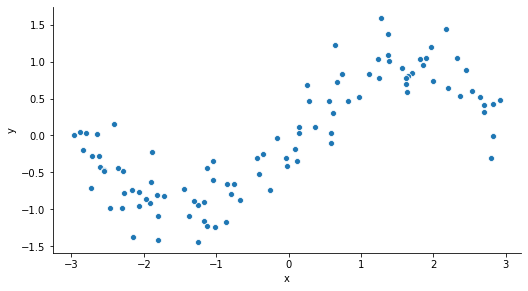

In [36]:
g = sns.relplot(data=data, x='x', y='y')
g.fig.set_size_inches(8,4)

In [66]:
# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='onehot-dense')
X_binned = enc.fit_transform(X.reshape(-1,1))
X_binned.shape

(100, 10)

In [67]:
X[:5]

array([[-0.75275929],
       [ 2.70428584],
       [ 1.39196365],
       [ 0.59195091],
       [-2.06388816]])

In [68]:
enc.bin_edges_[0]

array([-2.9668673 , -2.55299973, -2.0639171 , -1.3945301 , -1.02797432,
       -0.21514527,  0.44239288,  1.14612193,  1.63693428,  2.32784522,
        2.92132162])

In [69]:
X_binned[:5,:]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

+ 使用原始数据建模

In [70]:
# predict with original dataset
X = X.reshape(-1,1)

lr = LinearRegression().fit(X, y)
dtr = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(X, y)

+ 使用分箱后的数据建模

In [71]:
# predict with transformed dataset
lr_bin = LinearRegression().fit(X_binned, y)
dtr_bin = DecisionTreeRegressor(min_samples_split=3,random_state=0).fit(X_binned, y)

+ 绘图

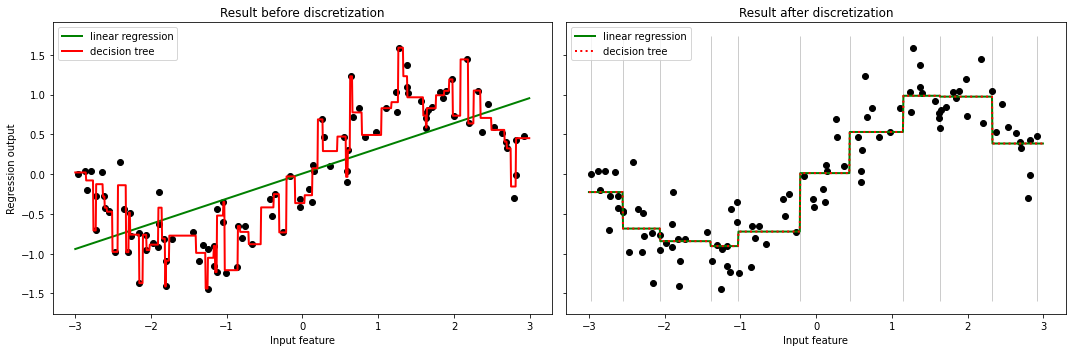

In [73]:
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
line_binned = enc.transform(line)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))

ax1.plot(X[:, 0], y, 'o', c='k')
ax1.plot(line, lr.predict(line), linewidth=2, color='green',
         label="linear regression")
ax1.plot(line, dtr.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")


ax2.plot(X[:, 0], y, 'o', c='k')
ax2.plot(line, lr_bin.predict(line_binned), linewidth=2, color='green',
         linestyle='-', label='linear regression')
ax2.plot(line, dtr_bin.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
# 绘制分箱的线
ax2.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")

plt.tight_layout()

使用 分箱+onehot 编码的方式，相当于扩充了特征个数，在更高维度上，数据集更有可能是线性可分的。  
但是对于 分箱+ordinal 编码的方式，则不一定。

+ 换一种分箱方式

In [55]:
# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='ordinal')
X_binned = enc.fit_transform(X.reshape(-1,1))
X_binned.shape

(100, 1)

In [56]:
X[:5]

array([[-0.75275929],
       [ 2.70428584],
       [ 1.39196365],
       [ 0.59195091],
       [-2.06388816]])

In [57]:
X_binned[:5,:]

array([[4.],
       [9.],
       [7.],
       [6.],
       [2.]])

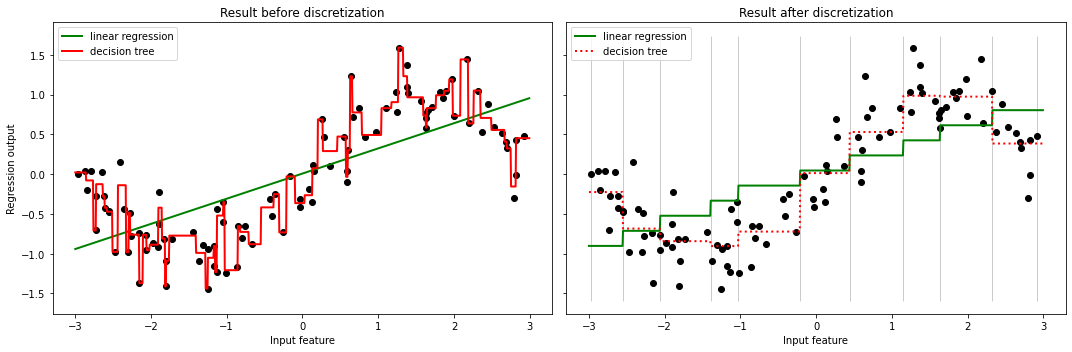

In [62]:
# predict with transformed dataset
lr_bin = LinearRegression().fit(X_binned, y)
dtr_bin = DecisionTreeRegressor(min_samples_split=3,random_state=0).fit(X_binned, y)


# 绘图
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
line_binned = enc.transform(line)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))

ax1.plot(X[:, 0], y, 'o', c='k')
ax1.plot(line, lr.predict(line), linewidth=2, color='green',
         label="linear regression")
ax1.plot(line, dtr.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")


ax2.plot(X[:, 0], y, 'o', c='k')
ax2.plot(line, lr_bin.predict(line_binned), linewidth=2, color='green',
         linestyle='-', label='linear regression')
ax2.plot(line, dtr_bin.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
ax2.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")

plt.tight_layout()

## 特征压缩

当分类特征的取值数量很大时，可以考虑对特征进行压缩，通常会使用如下两种方式：
1. 特征散列
2. 分箱计数

### 特征散列-???

### 分箱计数-KEY

> 参考《精通特征工程》-> 5.2.2 分箱计数.

这里的分箱计数不同于“连续变量的分段”，上述连续变量的分段只是考虑了变量本身，没有考虑目标变量。   

而分箱计数的思想是：**不是直接使用分类变量的值作为特征，而是使用目标变量取这个值的`条件概率`。**   
换句话说，不是对分类变量的值进行编码，而是计算分类变量值与目标变量之间的相关统计量

### 卡方分箱-KEY


+ 定义
  + 对于**数值型**特征，分箱是将其划分为若干个有限的区间
  + 对于**类别型**特征，分箱是将其合并成个数较少的几个类别，针对的是**取值过多的**情况

  分箱的目标是：
  > **将相似度高的样本划分到同一组**


+ 引入分箱的原因
  + 提高模型结果的稳定性
  + 对于类别型特征，分箱可以显著减少one-hot编码的特征个数


+ **卡方分箱法**  
  ChiMerge法采取**自底向上不断合并**的方法完成分箱操作，核心思想是：
  > 如果相邻两个区间的卡方值是最小的，意味着这两组样本的目标变量分布相似，可以合并

  
+ 卡方分箱大体步骤如下：

  1. 对特征$A$进行数值编码——以便支持排序
     + 对于**数值型**和**有序型**特征，它们本身就支持排序，可以跳过此步骤；
     + 对于**标称型**的特征，需要将其进行数值编码，以便能进行**排序**——常用的数值编码是对应取值的坏样本率
  2. 将特征 $A$ **排序** 后分成区间较多的若干组，设为 $A_1, A_2,..., A_n$
  3. 计算相邻两组样本的卡方值
  4. 找出上一步中卡方值最小的**相邻**两个组，将其合并成新的一箱
  5. 重复2和3，直到满足终止条件。

  
  常用的终止条件如下：
  + 某次合并后，最小卡方值的p值超过 0.9（意味着相邻两个区间的差异已经足够大）
  + 某次合并后，总的合并区间到达指定数量


+ 卡方分箱中的 **两个难点**  
  实际操作中，通常会对卡方分箱的结果有如下两个要求：
  1. 每箱同时包含好坏样本
  2. 分箱之后，各箱之间的坏样本率单调

+ **WOE编码和特征信息值IV**

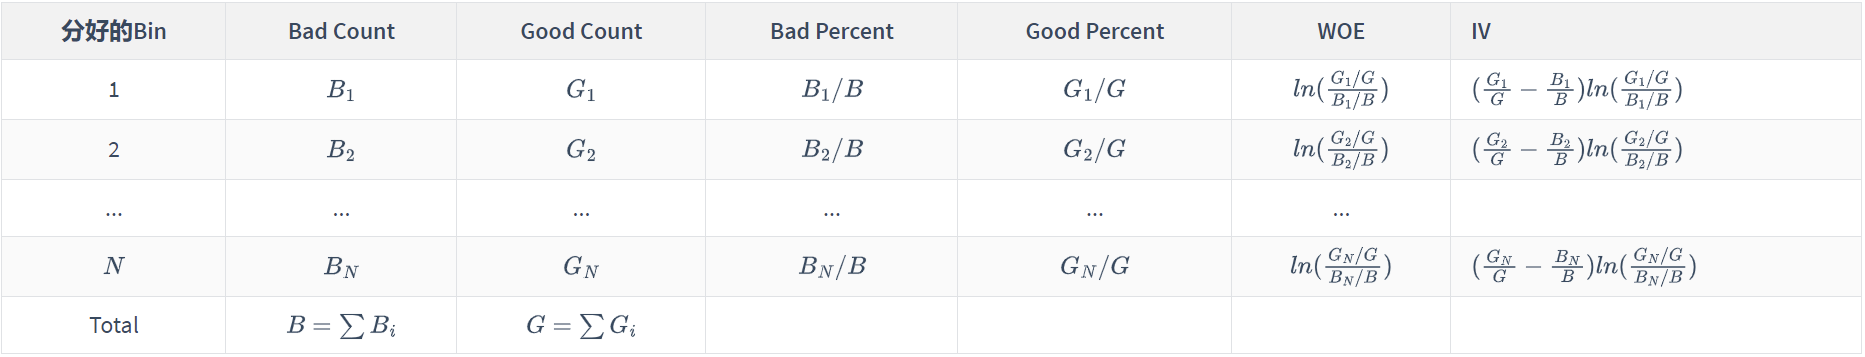

$WOE_i > 0$ 表示该箱里好样本的比例高于总体平均，也就是坏样本率低于总体平均

-----

# 特征分布变换

这里涉及到的内容是对数据做一些初始变换

## 对数变换和指数变换

对于分布严重偏斜的**正值数据**，可以通过进行**对数变换**的方式，缓解分布过于偏态的情况 。   

**对数函数可以对 $[1, \inf]$ 大数值的范围进行压缩，对 $[0, 1]$ 这部分小数值的范围进行扩展** 。  

通常经过对数变换之后，分布会接近于正态分布.

指数变换是个变换族，**对数变换只是它的一个特例**。用统计学术语来说，它们都是**方差稳定化**变换。

## Box-Cox变换

Box-Cox 变换是更加广义的一个变换，它可以 **将非正态分布的数据（正值）转换成近似正态分布的数据**.

--------------------

# 特征选择

> 特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性.  
> 它的最终目的是得到一个简约模型，**在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度**。  ——《精通特征工程》

## 方差过滤

通过特征本身的方差来筛选特征的类。  
比如一个特征本身的方差很小，就表示样本在这个特征上基本没有差异，可能特征中的大多数值都一样，甚至整个特征的取值都相同，那这个特征对于样本区分没有什么作用。  
所以**无论接下来的特征工程要做什么，都要优先消除方差近似于0的特征**.

sklearn中提供了如下类来完成此步骤：   
`feature_selection.VarianceThreshold(threshold=0.0)`  

+ 参数
  + threshold:过滤的方差阈值


+ 属性
  + variance_: shape=(n_featuers, )，记录了各个特征的方差
  + n_features_in_:


+ 方法
  + get_support(indices=False)，获取过滤的特征   
    + indices=False，返回的就是掩码
    + indices=True，返回的就是过滤后的特征索引

In [108]:
from sklearn.feature_selection import VarianceThreshold

X = np.array([[0, 1, 0, 3], [0, 2, 4, 3], [0, 2, 1, 3]])
variance_filter = VarianceThreshold(0.1)
display(X)

# 训练
variance_filter.fit(X)

# 查看过滤的方差阈值
print("\nvariance_filter.threshold : ", variance_filter.threshold)

# 查看每个特征的方差
print("\nvariance_filter.variances_ : ", variance_filter.variances_)

# 查看需要过滤的特征的掩码
print("\nvariance_filter.get_support(indices=False): ", variance_filter.get_support(indices=False))

# 查看过滤后剩余特征的index
print("\nvariance_filter.get_support(indices=True): ", variance_filter.get_support(indices=True))

# 转换
X_filter = variance_filter.transform(X)
print('\nX_filter:')
display(X_filter)

# 逆变换，无法还原原来的值，用0代替
print('\nX_filter_inverse:')
display(variance_filter.inverse_transform(X_filter))

array([[0, 1, 0, 3],
       [0, 2, 4, 3],
       [0, 2, 1, 3]])


variance_filter.threshold :  0.1

variance_filter.variances_ :  [0.         0.22222222 2.88888889 0.        ]

variance_filter.get_support(indices=False):  [False  True  True False]

variance_filter.get_support(indices=True):  [1 2]

X_filter:


array([[1, 0],
       [2, 4],
       [2, 1]])


X_filter_inverse:


array([[0, 1, 0, 0],
       [0, 2, 4, 0],
       [0, 2, 1, 0]])

## 相关性过滤-KEY

这部分又叫 **单变量过滤**，通常希望选出与标签相关且有意义的特征，因为这样的特征能够为我们提供大量信息。如果特征与标签无关，那只会白白浪费我们的计算内存，可能还会给模型带来噪音。  

在sklearn当中，我们有三种常用的方法来评判特征与标签之间的相关性：
1. 卡方 $\chi^2$ 检验   
卡方过滤是专门针对**离散型标签（即分类问题）**的相关性过滤。  
卡方检验函数`feature_selection.chi2`计算每个**非负特征**和标签之间的卡方统计量，并依照卡方统计量由高到低为特征排名。  


2. $F$ 检验  
又称ANOVA，方差齐性检验，是用来捕捉每个特征与标签之间 **线性关系** 的过滤方法。  
它即可以做回归也可以做分类，因此包含如下两个函数：
   + `feature_selection.f_classif`（F检验分类），用于标签是离散型变量的数据
   + `feature_selection.f_regression`（F检验回归），用于标签是连续型变量的数据。  

   需要注意的是，F检验在数据服从正态分布时效果会非常稳定，因此如果使用F检验过滤，通常会先将数据转换成服从正态分布的方式.

3. 互信息  
互信息法是用来捕捉每个特征与标签之间的任意关系（包括线性和非线性关系）的过滤方法。  
和F检验相似，它既可以做回归也可以做分类，包含两个函数：
   + `feature_selection.mutual_info_classif`（互信息分类）
   + `feature_selection.mutual_info_regression`（互信息回归）.    
   
   这两个类的用法和参数都和F检验一模一样，不过**互信息法比F检验更加强大，F检验只能够找出线性关系，而互信息法可以找出任意关系**.   
   **互信息法不返回p值或F值类似的统计量，它返回“每个特征与目标之间的互信息量的估计”，这个估计量在[0,1]之间取值，为0则表示两个变量独立，为1则表示两个变量完全相关**.

上述三种检验方法都需要结合`feature_selection.SelectKBest()`类使用，该类可以输入”评分标准“来选出前K个分数最高的特征，借此除去最可能独立于标签，与我们分类目的无关的特征.


`feature_selection.SelectKBest(score_func=<function f_classif>, *, k=10)`——这是类，根据传入的`score_func`计算各个特征的指标，然后选择前k个特征。  
+ 参数：
  + `score_func`，计算特征指标的函数，需要能接受 X, y两个参数，然后计算对应样本的score
  + `k`    
+ 返回值
  + `scores_`, shape=(n_features, )，各个特征的score
  + `pvalues_`, shape=(n_features, )，特征score对应的p值
+ 方法
  + get_support(indices=False)，获取过滤后的特征：indices=False返回掩码，indices=True返回特征的索引

**下面这三个都是函数，不是类**.  

1、卡方值  
`feature_selection.chi2(X, y)` —— 计算 X 中各个 **非负**特征 和 目标变量 y 的卡方值。  
返回值如下：
  + `chi`，各个特征的卡方值
  + `pval`，每个特征卡方值对应的p值
  

2、F检验  
`feature_selection.f_classif(X, y)` —— 分类；  
`feature_selection.f_regression(X, y, *, center=True)` —— 回归 ，`center`为True，就会对 X,y 进行中心化处理.  
返回值
  + `F`，各个特征的F值
  + `pval`，各个特征对应的p值
  
  
3、互信息  
`feature_selection.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)` —— 分类  
`feature_selection.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)` —— 回归  
  + `discrete_features`，用于决定每个特征是连续还是类别变量  
  取值为 `{‘auto’, bool, array-like}`, default=’auto’，
  + `n_neighbors`，int，用于指定计算互信息的neighbors
  + `copy`，布尔值，默认为True. 表示是否在原数组上进行操作  
  返回值
  + `mi`，各个特征的互信息
  
  
sklearn官方文档提供了一个Demo [Univariate Feature Selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py).

In [27]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression
from sklearn.datasets import load_digits

In [39]:
X, y = load_digits(return_X_y=True)
# 下面这个数据集比较大
# data = pd.read_csv("datasets/Digit-Recognizor.csv")
# X = data.iloc[:, 1:]
# y = data.iloc[:, 0]

display(X.shape)
display(y.shape)

(1797, 64)

(1797,)

In [30]:
# 进行 相关性过滤 之前，必须要先做方差过滤处理
variance_filter = VarianceThreshold()
X_var_filter = variance_filter.fit_transform(X)
X_var_filter.shape

(1797, 61)

In [31]:
# 这里选择 30 个特征
selector_chi2 = SelectKBest(score_func=chi2, k=30)
selector_chi2.fit(X, y)

SelectKBest(k=30, score_func=<function chi2 at 0x000001F3771B29D8>)

In [32]:
selector_chi2.scores_

array([          nan,  811.90700411, 3501.28249552,  698.9252572 ,
        438.52969882, 3879.81925999, 3969.45823205, 1193.5608181 ,
         24.79521396, 2953.83108764, 2583.65198939,  388.24205944,
        824.69094853, 3676.48924765, 1983.5796061 ,  597.24198237,
          8.95886124, 1924.21690377, 2409.27140681, 3556.31594594,
       4871.94194551, 4782.19921618, 2155.17378998,  376.76583333,
          7.90090158, 2471.82418401, 4515.48149826, 2986.64314847,
       3724.09567634, 3208.64686641, 5138.07412439,   35.71270718,
                 nan, 5688.25079535, 5262.46646904, 3165.0605867 ,
       3231.63943369, 2532.99695611, 3288.81403655,           nan,
        142.85082873, 3863.85787901, 6416.0867248 , 5448.25154235,
       4079.73153383, 2134.02540236, 4486.34097862,  313.53898127,
         70.39927392,  449.72327313, 2801.97224468, 1527.54519627,
       1653.15892311, 3073.99803898, 5251.21748723,  683.88227339,
          9.15254237,  851.06791492, 3800.2473108 ,  730.92975

In [33]:
selector_chi2.pvalues_

array([            nan, 5.81310493e-169, 0.00000000e+000, 1.17740541e-144,
       8.11314242e-089, 0.00000000e+000, 0.00000000e+000, 2.97727113e-251,
       3.20626273e-003, 0.00000000e+000, 0.00000000e+000, 4.41344943e-078,
       1.02825052e-171, 0.00000000e+000, 0.00000000e+000, 8.18335060e-123,
       4.41080315e-001, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.23435651e-075,
       5.44163062e-001, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.45801029e-005,
                   nan, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000,             nan,
       2.65875300e-026, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 3.49452723e-062,
       1.27145348e-011, 3.28604761e-091, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [38]:
chi2_features = selector_chi2.transform(X)
chi2_features.shape

(1797, 30)

## Embedded嵌入法-KEY

嵌入法是一种让算法自己决定使用哪些特征的方法，即特征选择和算法训练同时进行。  
在使用嵌入法时，**先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据权值系数从大到小选择特征**.

`feature_selection.SelectFromModel(estimator, *, threshold=None, prefit=False, norm_order=1, max_features=None, importance_getter='auto')`

+ 参数
  + `estimator`，使用的模型评估器，这个估计器必须要有`.feature_importance_`或者`.coef_`属性，用于评估特征.   
    **只要是带`feature_importances_`或者`coef_`属性，或带有l1和l2惩罚项的模型都可以使用**.
  + `threshold`，特征重要性的阈值，重要性低于这个阈值的特征都将被删除。  
  可以填 string 或者 float：
    + string时，可以是`mean`，`median`，表示阈值为所有特征重要性的均值或者中位数；
    + float时，直接指定的是阈值.
  + `prefit`，默认False.  
  如果传入的estimator已经调用过`.fit`方法进行训练了，这里就可以设置为True，此时就不会再对estimator进行训练。否则后续还需要调用`.fit`方式进行训练.
  + `norm_order`，尚不清楚如何使用
  + `max_features`，表示保留特征的最大个数.
  + `importance_getter`


+ `SelectFromModel`实例对象的属性
  + `estimator_`，基础的估计器
  + `threshhold_`，使用的特征重要性阈值



+ `SelectFromModel`实例对象的方法
  + `.fit(X,y)` 、`.transform(X,y)`或者 `.fit_transform(X,y)` 方法
  + `get_support(indices=False)`，获取筛选出来的特征的掩码或者index（indices=True）.

In [42]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = RandomForestClassifier(n_estimators=10)
# 嵌入法选择特征
rfc_embedded = SelectFromModel(estimator=rfc, threshold=0.005)
rfc_embedded.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10, n_jobs=None,
                                                 oob_score=False,


In [46]:
X_embedded = rfc_embedded.transform(X)

In [47]:
display(X.shape)
display(X_embedded.shape)

(1797, 64)

(1797, 44)

In [50]:
# 获取被选择的特征的index
rfc_embedded.get_support(indices=True)

array([ 2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 25,
       26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46,
       50, 51, 52, 53, 54, 58, 59, 60, 61, 62], dtype=int64)

In [51]:
rfc_embedded.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
rfc_embedded.threshold_

0.005

## Wrapper包装法

包装法也是一个特征选择和算法训练同时进行的方法，与嵌入法十分相似，它也是依赖于算法自身的选择，比如coef_属性或feature_importances_属性来完成特征选择。  
但不同的是，包装法**往往使用一个目标函数作为黑盒来帮助我们选取特征，而不是自己输入某个评估指标或统计量的阈值**。  
包装法的步骤如下：
1. 在初始特征集上训练评估器，并且通过 `coef_` 属性或通过 `feature_importances_` 属性获得每个特征的重要性
2. 从当前的一组特征中修剪最不重要的特征
3. 在修剪过特征之后的特征集上再次进行1、2中的评估
4. 直到减小至设置的特征数量.

包装法和嵌入法的区别在于：**嵌入法一次训练即可，包装法要不断的减少特征子集并进行多次训练，所以包装法的计算成本很大**.

sklearn中的包装法主要是RFE方法——Recursive Feature Elimination.
+ `feature_selection.RFE(estimator, *, n_features_to_select=None, step=1, verbose=0, importance_getter='auto')`
  + `estimator`，使用的模型评估器，这个估计器必须要有`.feature_importance_`或者`.coef_`属性，用于评估特征
  + `n_features_to_select`，最终留下的特征数量，可以是：
    + `int`，直接指定留下的特征数
    + `float`，$[0, 1]$ 之间，表示留下的特征比例.
  + `step`，每一步中需要消除的特征个数
    + `int`，直接是特征个数
    + `float`，$[0, 1]$ 之间，每一步中消除的特征比例.
  + `importance_getter`
  
+ `RFE`实例对象的属性：
  + `estimator_`
  + `n_features_`
  + `ranking_`
  + `support_`
  
+ `RFE`实例对象的方法：
  + `fit`、`transform` 和 `fit_transform` 方法
  + `get_support_(indice=False)`，获取筛选出来的特征
  + `decision_function(X)`，
  + `predict(X)`
  + `predict_proba(X)`
  + `predict_log_proba(X)`

In [53]:
from sklearn.feature_selection import RFE

In [55]:
rfc = RandomForestClassifier(n_estimators=10)
# 嵌入法选择特征
rfc_rfe = RFE(estimator=rfc, n_features_to_select=40, step=2)
rfc_rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=40, step=2, verbose=0)

In [56]:
X_rfc = rfc_rfe.transform(X)

In [57]:
X_rfc.shape

(1797, 40)

In [58]:
rfc_rfe.get_support(indices=True)

array([ 2,  3,  4,  5,  9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 25, 26, 27,
       28, 29, 30, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 50, 51, 52,
       53, 54, 58, 60, 61, 62], dtype=int64)

--------------------

# 特征降维

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [61]:
iris = load_iris()
display(iris.keys())
print(iris.feature_names)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [63]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
display(X.shape)
display(y.shape)
X.head()

(150, 4)

(150,)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## PCA降维

In [64]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
X_rd = pca.transform(X)
X_rd.shape

(150, 2)

In [67]:
np.unique(y)

array([0, 1, 2])

绘制降维后的图像

Text(0.5, 1.0, 'PCA of iris data')

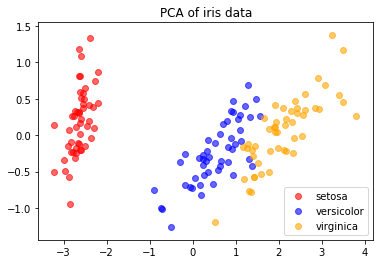

In [68]:
colors = ['red','blue','orange']
plt.figure()
for y_value in np.unique(y):
    plt.scatter(X_rd[y == y_value,0], X_rd[y == y_value, 1], alpha=0.6, c=colors[y_value], label = iris.target_names[y_value])
plt.legend()
plt.title("PCA of iris data")

In [69]:
# 查看前n个主成分的方差
pca.explained_variance_

array([4.22824171, 0.24267075])

In [70]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [71]:
# 查看两个主成分
# 2行对应于提取出的两个主成分，4对应于原有的4个特征
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [72]:
pca.components_.shape

(2, 4)

### 利用PCA降维探索人脸数据集

In [73]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [36]:
type(faces)

sklearn.utils.Bunch

In [37]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

faces里是1348张人脸图片，存储在images里，每张图片是62*47个像素大小
data里有1348行，对应于1348张图片，每张图片在这里被拉成了一个行向量

In [39]:
faces.data.shape

(1348, 2914)

In [41]:
faces.images.shape

(1348, 62, 47)

可视化原有图像

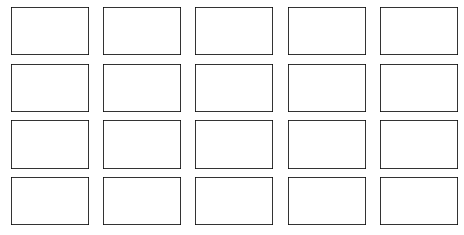

In [43]:
fig, axes = plt.subplots( nrows=4, ncols=5, figsize = (8,4), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i,:,:], cmap = 'gray')

建模降维

In [54]:
# 原本的数据有2914维（data里的），现在降到150维
pca = PCA(n_components=150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [80]:
components = pca.components_
data_rd = pca.transform(faces.data)
data_reverse = pca.inverse_transform(data_rd)

In [81]:
faces.data.shape

(1348, 2914)

In [82]:
components.shape

(150, 2914)

In [83]:
data_rd.shape

(1348, 150)

In [84]:
data_reverse.shape

(1348, 2914)

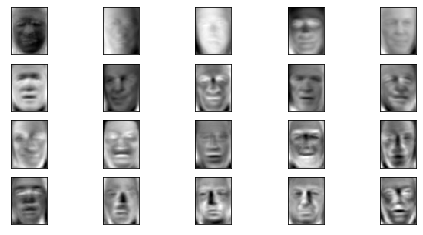

In [79]:
fig, axes = plt.subplots( nrows=4, ncols=5, figsize = (8,4), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i,:].reshape(62,47), cmap = 'gray')

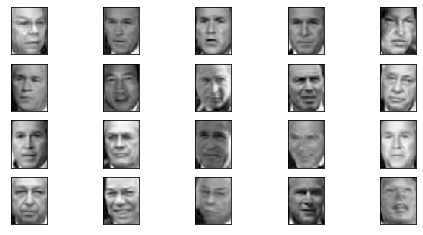

In [85]:
fig, axes = plt.subplots( nrows=4, ncols=5, figsize = (8,4), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(data_reverse[i,:].reshape(62,47), cmap = 'gray')

## T-SNE

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

C:\Users\cm\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [32]:
iris = load_iris()
data = pd.DataFrame(iris.data,columns=iris.feature_names)

In [71]:
tsne = TSNE(n_components=2)
df_trans = tsne.fit_transform(data)

In [72]:
df_trans.shape

(150, 2)

In [130]:
data_trans = pd.DataFrame(np.hstack((df_trans, iris.target.reshape(-1,1))), columns=['x','y','category'])

In [131]:
data_trans.shape

(150, 3)

In [132]:
data_trans.head()

,x,y,category
0,-22.406197,10.156743,0.0
1,-20.005274,9.633954,0.0
2,-19.642643,10.316407,0.0
3,-19.413977,10.521431,0.0
4,-22.438202,10.598161,0.0


In [133]:
data_trans['category'].value_counts()

2.0    50
1.0    50
0.0    50
Name: category, dtype: int64

In [134]:
d = dict(zip([0,1,2], list(iris.target_names)))
data_trans['category_name'] = data_trans['category'].replace(d)

In [135]:
data_trans.head()

,x,y,category,category_name
0,-22.406197,10.156743,0.0,setosa
1,-20.005274,9.633954,0.0,setosa
2,-19.642643,10.316407,0.0,setosa
3,-19.413977,10.521431,0.0,setosa
4,-22.438202,10.598161,0.0,setosa


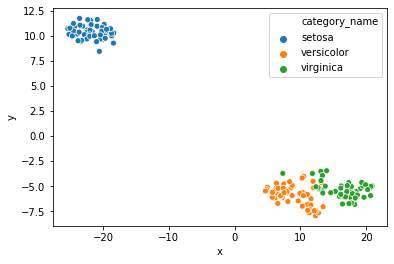

In [136]:
sns.scatterplot(data=data_trans, x='x',y='y', hue='category_name')

--------------------

# 特征提取

特征提取也是特征工程的一种，不过特征提取涵盖的范围很大，所以这里单独拿出来讲了。

下面是sklearn中的特征映射类.  

`feature_extraction.DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sparse=True, sort=True)` .    
+ Transforms lists of feature-value mappings to vectors —— 这个类会将lists of mappings (dict-like objects)转换成numpy类型的特征值，list中的每个元素都是一个 feature_name -> feature_value 的键值对.
+ 默认以稀疏矩阵的形式存储。   
+ 当list的映射元素中，特征的值是string的时候，会使用oneHot编码.

类的初始化参数列表：
+ `dtype`，特征的值的类型, default=np.float64
+ **separator**：string, default=”=”.  对string类型的特征值进行One-Hot编码时，特征名称之间的分割符
+ **sparse**：boolean, optional. 是否以稀疏矩阵的形式返回，默认为True.


类对象的属性：
+ **vocabulary_**：dict, 一个将feature_name映射到特征的indice的字典.
+ **feature_names_**：list, 一个包含特征名称的列表.

类的重要实例方法：
+ `fit(self, X[, y])` Learn a list of feature name -> indices mappings.
+ `transform(self, X)` Transform feature->value dicts to array or sparse matrix.
+ `fit_transform(self, X[, y])` Learn a list of feature name -> indices mappings and transform X.
+ `get_feature_names(self)` Returns a list of feature names, ordered by their indices.
+ `inverse_transform(self, X[, dict_type])` Transform array or sparse matrix X back to feature mappings.
+ `restrict(self, support[, indices])` Restrict the features to those in support using feature selection.

In [1]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
# 默认会使用稀疏表示，这里关闭了这个选项
v = DictVectorizer(sparse=False)

In [24]:
# 输入是一个字典构成的列表，每一个字典对应于一个观测
X = [{'feature-1': 1, 'feature-2': 2}, {'feature-1': 3, 'feature-3': 1}]

# 学习字典中的特征映射
v.fit(X)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [25]:
v.vocabulary_

{'feature-1': 0, 'feature-2': 1, 'feature-3': 2}

In [26]:
v.feature_names_

['feature-1', 'feature-2', 'feature-3']

In [27]:
# 将原有的 list of dict 转成特征矩阵
# X 中有两个dict，对应于两个观测，一共有三个特征，所以有三个特征列，没有出现的特征取值为0
X_fit = v.transform(X)
X_fit

array([[1., 2., 0.],
       [3., 0., 1.]])

In [28]:
# 逆变换
v.inverse_transform(X_fit)

[{'feature-1': 1.0, 'feature-2': 2.0}, {'feature-1': 3.0, 'feature-3': 1.0}]

In [29]:
# 对于 训练集 中没有出现过的特征，会直接被忽略
v.transform({'feature-1': 4, 'unseen_feature': 3})

array([[4., 0., 0.]])

In [30]:
# 如果特征的value 不是数值而是string，就采用one-hot编码
v = DictVectorizer(sparse=False)
X = [{'feature-1': 'a', 'feature-2': 'b'}, {'feature-1': 'c', 'feature-3': 'd'}]
v.fit(X)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [33]:
# 这里 one-hot 编码时，特征名称之间默认使用 = 号连接
v.feature_names_

['feature-1=a', 'feature-1=c', 'feature-2=b', 'feature-3=d']

In [34]:
v.vocabulary_

{'feature-1=a': 0, 'feature-1=c': 1, 'feature-2=b': 2, 'feature-3=d': 3}

In [35]:
v.transform(X)

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.]])

## 文本特征提取

`sklearn.feature_extraction.text`这个子模块提供了一些文本特征提取的类.

### Bag-of-word表示

用于将一系列文本文档转换成 a matrix of token counts，也就是 **Bag-of-word** 特征 . 

`text.CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)`  

类的构造参数：
+ `input`：string {‘filename’, ‘file’, ‘content’}
+ `encoding`：string, ‘utf-8’ by default
+ `decode_error`：{‘strict’, ‘ignore’, ‘replace’}, default=’strict’
+ `strip_accents`：{‘ascii’, ‘unicode’}, default=None
+ **`lowercase`：boolean, True by default.  是否先转成小写**
+ `preprocessor`：callable, default=None. 自定义预处理的函数
+ `tokenizer`：callable, default=None.  自定义分词的函数
+ **`stop_words`：string {‘english’}, list, or None (default). 停用词的集合，默认下为空。**  
  + 如果为`english`，使用的默认的一个英语停用词集合，这个集合不是很实用
  + 自定义的话，传入一个停用词组成的list，只在`analyzer='word'`时生效
  + `None`表示不使用停用词集合
+ `token_pattern`，用于提取词语(token)的正则表达式，符合这个表达式的词语会被提取出来
+ `ngram_range`：tuple (min_n, max_n), default=(1, 1). 指定n-gram模型的单词个数
+ `analyzer`：{‘word’, ‘char’, ‘char_wb’} or callable, default=’word’. 指定词法分析器，设置为 word 级别还是 character 级别.
+ `vocabulary`：Mapping or iterable, default=None. **手动指定词表和相应的特征映射关系** .   
如果手动指定了这个参数，那么下面的`min_df`和`max_df`都会被忽略。
+ `min_df`：default=1. 用于设置单词至少在多少个文档中出现，才会被计入特征，取值有两种：
  + int，设置最低出现的文档次数
  + float in range[0, 1]，设置最低出现的比例
+ `max_df`：default=None. 用于过滤频次过高的token，取值和`min_df`一样
+ `max_features`：int, default=1. 设置最大的特征个数，会按照频次从高到低依次取.
+ `binary`，是否采用0-1表示，也就是单词出现了就为1，不出现为0，忽略count. 默认为`False`.
+ `dtype`，返回的矩阵的元素类型


类对象的属性：
+ `vocabulary_`：dict，记录了将word映射到特征的index.
+ `fixed_vocabulary_`: boolean, `True`表示 word -> index 的特征映射词典的顺序是由用户指定的，也就是`vocabulary`这个参数由用户指定.
+ `stop_words_`：set  
被当做停用词忽略的词:
  occurred in too many documents (max_df)；
  occurred in too few documents (min_df)；
  were cut off by feature selection (max_features).


类对象的方法：

+ `fit(self, raw_documents[, y])`Learn a vocabulary dictionary of all tokens in the raw documents.

+ `transform(self, raw_documents)` Transform documents to document-term matrix.

+ `fit_transform(self, raw_documents[, y])` Learn the vocabulary dictionary and return term-document matrix.

+ `get_feature_names(self)` Array mapping from feature integer indices to feature name.

+ `get_params(self[, deep])` Get parameters for this estimator.

+ `get_stop_words(self)` Build or fetch the effective stop words list.

+ `inverse_transform(self, X)` Return terms per document with nonzero entries in X.

+ `set_params(self, \*\*params)` Set the parameters of this estimator.

+ `decode(self, doc)` Decode the input into a string of unicode symbols.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
corpus = [
    'This is the first document. This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [51]:
# 构造特征的 词表
vectorizer.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

In [41]:
vectorizer.fixed_vocabulary_

False

In [42]:
vectorizer.stop_words_

set()

In [45]:
vectorizer.get_stop_words()

In [44]:
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [49]:
corpus_fit = vectorizer.transform(corpus)
# 得到的是一个稀疏矩阵
corpus_fit.toarray()

array([[0, 2, 2, 2, 0, 0, 2, 0, 2],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [50]:
# 这里选择使用 binary 表示
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(corpus)
corpus_fit = vectorizer.transform(corpus)
# 得到的是一个稀疏矩阵
corpus_fit.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

### TF-IDF表示

sklearn提供了两个类来进行IF-IDF特征提取：
1. `text.TfidfTransformer()`
  + **这个类接受`CountVectorizer()`生成的稀疏矩阵，将其转换成 tf-idf 特征**
  + `text.TfidfTransformer(*, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)`  
  + 这个类的构造参数不用做什么变动，直接接受`CountVectorizer()`的结果就行了.
2. `text.TfidfVectorizer()`  
  + **这个类直接从原始文本中生成 tf-idf 特征**
  + `text.TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)`  
  + 这个类的参数和`CountVectorizer()`是一致的，最后的几个参数也不用管.
  
上述两个类的属性值
+ `text.TfidfTransformer()`只有一个`.idf_`属性，记录的是各个文档对应的idf
+ `text.TfidfVectorizer()`含有的属性值和`DictVectorizer()`一样，此外还多一个`.idf_`

In [53]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [54]:
corpus = [
    'This is the first document. This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]

In [55]:
cnt_vec = CountVectorizer()
tfidf_trans = TfidfTransformer()
tfidf_vec = TfidfVectorizer()

In [60]:
# 使用 TfidfTransformer() 要先使用 DictVectorize() 类生成 BOW 的频数矩阵
cnt_vec.fit(corpus)
corpus_cnt = cnt_vec.transform(corpus)
# 输入必须是 count 的（稀疏）矩阵
tfidf_trans.fit(corpus_cnt)
corpus_trans = tfidf_trans.transform(corpus_cnt)

In [61]:
# TfidfVectorizer() 相当于 DictVectorize() + TfidfTransformer()，一步完成
tfidf_vec.fit(corpus)
corpus_vec = tfidf_vec.transform(corpus)

In [62]:
corpus_trans.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

In [63]:
corpus_vec.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

In [64]:
tfidf_trans.idf_

array([1.91629073, 1.22314355, 1.51082562, 1.        , 1.91629073,
       1.91629073, 1.        , 1.91629073, 1.        ])

In [65]:
tfidf_vec.idf_

array([1.91629073, 1.22314355, 1.51082562, 1.        , 1.91629073,
       1.91629073, 1.        , 1.91629073, 1.        ])

--------------------

# 特征创造-Todo

# 样本不平衡问题

python中专门处理样本不平衡的package是`imbalanced-learn`，GitHub地址为[imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)，文档地址为[Welcome to imbalanced-learn documentation!](https://imbalanced-learn.readthedocs.io/en/stable/index.html)。

安装  
```python
conda install -c conda-forge imbalanced-learn=0.6.2
```

注意，`imbalanced-learn`对于scikit-learn的版本有要求，最新的0.7.0版imbalanced-learn对scikit-learn的要求是 0.23 以上，但是 conda 的库里最新的scikit-learn是 0.22 的，会导致使用imbalanced-learn 时报错，所以需要安装 0.6.2 版本的。

## SMOTE

对少数类样本进行合成过采样，使用`imblearn.over_sampling.SMOTE`来完成.

类的初始化签名为：`class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=1)`
+ `sampling_strategy`: 可以是 float, str, dict or callable, (default=’auto’). 这里主要介绍 float 和 str 这两种参数.
  + 传入的值为 float 时，表示的是如下比例：少数类过采样后的样本数 / 多数类的样本数，需要注意的是，**float 只能用于 二分类问题**。
  + 传入的值为 str 时，可以取如下值：
    + 
+ `random_state`:int, RandomState instance or None, optional (default=None)——也就是随机数生成的种子（状态）.
+ `k_neighbors`:int or object, optional (default=5) —— 合成样本时使用的最近邻个数.

初始化后，调用`.fit_resample(X,y)`方法即可.

In [8]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import sklearn
import imblearn

print("slearn version:   ",sklearn.__version__)
print("imblearn version: ",imblearn.__version__)

slearn version:    0.22.1
imblearn version:  0.6.2


In [12]:
# 构建1000个样本，总共 2 个特征，都是有效特征，二分类，每个类别只有一个中心，每个类别的数量占比为 1:9
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                           weights=[0.1, 0.9], class_sep=2,  flip_y=0, random_state=10)

print(X.shape)
print(y.shape)
print('Original dataset distribution: {}'.format(Counter(y)))

(1000, 2)
(1000,)
Original dataset distribution: Counter({1: 900, 0: 100})


In [11]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)
print('Resampled dataset distribution: {}'.format(Counter(y_res)))

(1800, 2)
(1800,)
Resampled dataset distribution: Counter({1: 900, 0: 900})


---------------------

# 常用的一些pandas函数

In [5]:
data = {'one' : pd.Series([1.,2.,3.],index=['a', 'b', 'c']),
   'two' : pd.Series([1.,2.,3.,4.],index=['a', 'b', 'c', 'd']),
   'three':pd.Series([5,6,7,8],index=['a','b','c','d'])}
df = pd.DataFrame(data)

In [6]:
df

,one,two,three
a,1.0,1.0,5
b,2.0,2.0,6
c,3.0,3.0,7
d,NaN,4.0,8


In [7]:
# 同一个cell输出多个结果
display(df)
df

,one,two,three
a,1.0,1.0,5
b,2.0,2.0,6
c,3.0,3.0,7
d,NaN,4.0,8


,one,two,three
a,1.0,1.0,5
b,2.0,2.0,6
c,3.0,3.0,7
d,NaN,4.0,8


+ 检查缺失值位置

In [8]:
df.isnull()

,one,two,three
a,False,False,False
b,False,False,False
c,False,False,False
d,True,False,False


In [9]:
df.isnull().sum()

one      1
two      0
three    0
dtype: int64

+ 判断DF中是否含有某些元素

In [10]:
df.isin([6,7])

,one,two,three
a,False,False,False
b,False,False,True
c,False,False,True
d,False,False,False


In [11]:
df['three'].isin([6,7])

a    False
b     True
c     True
d    False
Name: three, dtype: bool

In [12]:
# 过滤出 three 这一列包含 [6,7] 的记录
df.loc[df['three'].isin([6,7])]

,one,two,three
b,2.0,2.0,6
c,3.0,3.0,7


+ 排序相关

In [13]:
df.sort_values(by=['three'], axis=0, ascending=False, inplace=False)

,one,two,three
d,NaN,4.0,8
c,3.0,3.0,7
b,2.0,2.0,6
a,1.0,1.0,5


+ 计算某一列的取值个数, 注意，只有Series有这个函数，DF没有

In [14]:
df['three'].value_counts()

7    1
6    1
5    1
8    1
Name: three, dtype: int64

+ 错行（列）相减  
可以使用`df.shift()`和`df.diff()`两种函数实现

In [15]:
df

,one,two,three
a,1.0,1.0,5
b,2.0,2.0,6
c,3.0,3.0,7
d,NaN,4.0,8


In [16]:
df.shift(periods=1)

,one,two,three
a,NaN,NaN,NaN
b,1.0,1.0,5.0
c,2.0,2.0,6.0
d,3.0,3.0,7.0


In [17]:
df.diff()

,one,two,three
a,NaN,NaN,NaN
b,1.0,1.0,1.0
c,1.0,1.0,1.0
d,NaN,1.0,1.0


## TODO

+ 下面的例子中， `df[ ['col1','col2']  ]` 得到的是 view，但是紧随其后使用`.fillna()`时，却是在 copy 上执行的，不知道为什么

In [ ]:
df = pd.DataFrame(np.arange(6).reshape(2,3), columns=['a','b','c'])
df.iloc[0,:] = np.nan
df

In [168]:
# df[['a','b']] = 10
# df[['a','b']].fillna(0, inplace=True)
# df.loc[:,['a','b']] = 10
df.loc[:,['a','b']].fillna(0, inplace=True)
df

,a,b,c
0,NaN,NaN,NaN
1,3.0,4.0,5.0
